## Release the Kraken!

In [ ]:
# The next library we're going to look at is called Kraken, which was developed by Université 
# PSL in Paris. It's actually based on a slightly older code base, OCRopus. You can see how the
# flexible open-source licenses allow new ideas to grow by building upon older ideas. And, in
# this case, I fully support the idea that the Kraken - a mythical massive sea creature - is the
# natural progression of an octopus!
#
# What we are going to use Kraken for is to detect lines of text as bounding boxes in a given
# image. The biggest limitation of tesseract is the lack of a layout engine inside of it. Tesseract
# expects to be using fairly clean text, and gets confused if we don't crop out other artifacts.
# It's not bad, but Kraken can help us out be segmenting pages. Lets take a look.

In [1]:
# First, we'll take a look at the kraken module itself
# kraken is not supported on windows. it works only on Mac os and linux
# KRAKEN DOESNT RUN ON WINDOWS
import kraken
help(kraken)

Help on package kraken:

NAME
    kraken - entry point for kraken functionality

PACKAGE CONTENTS
    align
    binarization
    blla
    ketos
    kraken
    lib (package)
    linegen
    pageseg
    repo
    rpred
    serialization
    transcribe

FILE
    c:\programdata\anaconda3\lib\site-packages\kraken\__init__.py




In [ ]:
# There isn't much of a discussion here, but there are a number of sub-modules that look
# interesting. I spend a bit of time on their website, and I think the pageseg module, which
# handles all of the page segmentation, is the one we want to use. Lets look at it
from kraken import pageseg
# help(pageseg)

In [ ]:
# So it looks like there are a few different functions we can call, and the segment
# function looks particularly appropriate. I love how expressive this library is on the
# documentation front -- I can see immediately that we are working with PIL.Image files,
# and the author has even indicated that we need to pass in either a binarized (e.g. '1')
# or grayscale (e.g. 'L') image. We can also see that the return value is a dictionary
# object with two keys, "text_direction" which will return to us a string of the
# direction of the text, and "boxes" which appears to be a list of tuples, where each
# tuple is a box in the original image.
#
# Lets try this on the image of text. I have a simple bit of text in a file called
# two_col.png which is from a newspaper on campus here
from PIL import Image
im=Image.open("readonly/two_col.png")
# Lets display the image inline
display(im)
# Lets now convert it to black and white and segment it up into lines with kraken
bounding_boxes=pageseg.segment(im.convert('1'))['boxes']
# And lets print those lines to the screen
print(bounding_boxes)

In [ ]:
# Ok, pretty simple two column text and then a list of lists which are the bounding boxes of 
# lines of that text. Lets write a little routine to try and see the effects a bit more
# clearly. I'm going to clean up my act a bit and write real documentation too, it's a good
# practice
def show_boxes(img):
    '''Modifies the passed image to show a series of bounding boxes on an image as run by kraken
    
    :param img: A PIL.Image object
    :return img: The modified PIL.Image object
    '''
    # Lets bring in our ImageDraw object
    from PIL import ImageDraw
    # And grab a drawing object to annotate that image
    drawing_object=ImageDraw.Draw(img)
    # We can create a set of boxes using pageseg.segment
    bounding_boxes=pageseg.segment(img.convert('1'))['boxes']
    # Now lets go through the list of bounding boxes
    for box in bounding_boxes:
        # An just draw a nice rectangle
        drawing_object.rectangle(box, fill = None, outline ='red')
    # And to make it easy, lets return the image object
    return img

# To test this, lets use display
display(show_boxes(Image.open("readonly/two_col.png")))

In [ ]:
# Not bad at all! It's interesting to see that kraken isn't completely sure what to do with this
# two column format. In some cases, kraken has identified a line in just a single column, while
# in other cases kraken has spanned the line marker all the way across the page. Does this matter?
# Well, it really depends on our goal. In this case, I want to see if we can improve a bit on this.
#
# So we're going to go a bit off script here. While this week of lectures is about libraries, the
# goal of this last course is to give you confidence that you can apply your knowledge to actual
# programming tasks, even if the library you are using doesn't quite do what you want. 
#
# I'd like to pause the video for the moment and collect your thoughts. Looking at the image above,
# with the two column example and red boxes, how do you think we might modify this image to improve
# kraken's ability to text lines?

In [ ]:
# Thanks for sharing your thoughts, I'm looking forward to seeing the breadth of ideas that everyone
# in the course comes up with. Here's my partial solution -- while looking through the kraken docs on 
# the pageseg() function I saw that there are a few parameters we can supply in order to improve 
# segmentation. One of these is the black_colseps parameter. If set to True, kraken will assume that 
# columns will be separated by black lines. This isn't our case here, but, I think we have all of the
# tools to go through and actually change the source image to have a black separator between columns.
#
# The first step is that I want to update the show_boxes() function. I'm just going to do a quick
# copy and paste from the above but add in the black_colseps=True parameter
def show_boxes(img):
    '''Modifies the passed image to show a series of bounding boxes on an image as run by kraken
    
    :param img: A PIL.Image object
    :return img: The modified PIL.Image object
    '''
    # Lets bring in our ImageDraw object
    from PIL import ImageDraw
    # And grab a drawing object to annotate that image
    drawing_object=ImageDraw.Draw(img)
    # We can create a set of boxes using pageseg.segment
    bounding_boxes=pageseg.segment(img.convert('1'), black_colseps=True)['boxes']
    # Now lets go through the list of bounding boxes
    for box in bounding_boxes:
        # An just draw a nice rectangle
        drawing_object.rectangle(box, fill = None, outline ='red')
    # And to make it easy, lets return the image object
    return img

In [ ]:
# The next step is to think of the algorithm we want to apply to detect a white column separator.
# In experimenting a bit I decided that I only wanted to add the separator if the space of was
# at least 25 pixels wide, which is roughly the width of a character, and six lines high. The
# width is easy, lets just make a variable
char_width=25
# The height is harder, since it depends on the height of the text. I'm going to write a routine
# to calculate the average height of a line
def calculate_line_height(img):
    '''Calculates the average height of a line from a given image
    :param img: A PIL.Image object
    :return: The average line height in pixels
    '''
    # Lets get a list of bounding boxes for this image
    bounding_boxes=pageseg.segment(img.convert('1'))['boxes']
    # Each box is a tuple of (top, left, bottom, right) so the height is just top - bottom
    # So lets just calculate this over the set of all boxes
    height_accumulator=0
    for box in bounding_boxes:
        height_accumulator=height_accumulator+box[3]-box[1]
        # this is a bit tricky, remember that we start counting at the upper left corner in PIL!
    # now lets just return the average height
    # lets change it to the nearest full pixel by making it an integer
    return int(height_accumulator/len(bounding_boxes))

# And lets test this with the image with have been using
line_height=calculate_line_height(Image.open("readonly/two_col.png"))
print(line_height)

In [ ]:
# Ok, so the average height of a line is 31.
# Now, we want to scan through the image - looking at each pixel in turn - to determine if there
# is a block of whitespace. How bit of a block should we look for? That's a bit more of an art
# than a science. Looking at our sample image, I'm going to say an appropriate block should be
# one char_width wide, and six line_heights tall. But, I honestly just made this up by eyeballing
# the image, so I would encourage you to play with values as you explore.
# Lets create a new box called gap box that represents this area
gap_box=(0,0,char_width,line_height*6)
gap_box

In [ ]:
# It seems we will want to have a function which, given a pixel in an image, can check to see
# if that pixel has whitespace to the right and below it. Essentially, we want to test to see
# if the pixel is the upper left corner of something that looks like the gap_box. If so, then
# we should insert a line to "break up" this box before sending to kraken
#
# Lets call this new function gap_check
def gap_check(img, location):
    '''Checks the img in a given (x,y) location to see if it fits the description
    of a gap_box
    :param img: A PIL.Image file
    :param location: A tuple (x,y) which is a pixel location in that image
    :return: True if that fits the definition of a gap_box, otherwise False
    '''
    # Recall that we can get a pixel using the img.getpixel() function. It returns this value
    # as a tuple of integers, one for each color channel. Our tools all work with binarized
    # images (black and white), so we should just get one value. If the value is 0 it's a black
    # pixel, if it's white then the value should be 255
    #
    # We're going to assume that the image is in the correct mode already, e.g. it has been
    # binarized. The algorithm to check our bounding box is fairly easy: we have a single location 
    # which is our start and then we want to check all the pixels to the right of that location 
    # up to gap_box[2]
    for x in range(location[0], location[0]+gap_box[2]):
        # the height is similar, so lets iterate a y variable to gap_box[3]
        for y in range(location[1], location[1]+gap_box[3]):
            # we want to check if the pixel is white, but only if we are still within the image
            if x < img.width and y < img.height:
                # if the pixel is white we don't do anything, if it's black, we just want to
                # finish and return False
                if img.getpixel((x,y)) != 255:
                    return False
    # If we have managed to walk all through the gap_box without finding any non-white pixels
    # then we can return true -- this is a gap!
    return True

In [ ]:
# Alright, we have a function to check for a gap, called gap_check. What should we do once
# we find a gap? For this, lets just draw a line in the middle of it. Lets create a new function
def draw_sep(img,location):
    '''Draws a line in img in the middle of the gap discovered at location. Note that
    this doesn't draw the line in location, but draws it at the middle of a gap_box
    starting at location.
    :param img: A PIL.Image file
    :param location: A tuple(x,y) which is a pixel location in the image
    '''
    # First lets bring in all of our drawing code
    from PIL import ImageDraw
    drawing_object=ImageDraw.Draw(img)
    # next, lets decide what the middle means in terms of coordinates in the image
    x1=location[0]+int(gap_box[2]/2)
    # and our x2 is just the same thing, since this is a one pixel vertical line
    x2=x1
    # our starting y coordinate is just the y coordinate which was passed in, the top of the box
    y1=location[1]
    # but we want our final y coordinate to be the bottom of the box
    y2=y1+gap_box[3]
    drawing_object.rectangle((x1,y1,x2,y2), fill = 'black', outline ='black')
    # and we don't have anything we need to return from this, because we modified the image

In [ ]:
# Now, lets try it all out. This is pretty easy, we can just iterate through each pixel 
# in the image, check if there is a gap, then insert a line if there is.
def process_image(img):
    '''Takes in an image of text and adds black vertical bars to break up columns
    :param img: A PIL.Image file
    :return: A modified PIL.Image file
    '''
    # we'll start with a familiar iteration process
    for x in range(img.width):
        for y in range(img.height):
            # check if there is a gap at this point
            if (gap_check(img, (x,y))):
                # then update image to one which has a separator drawn on it
                draw_sep(img, (x,y))
    # and for good measure we'll return the image we modified
    return img

# Lets read in our test image and convert it through binarization
i=Image.open("readonly/two_col.png").convert("L")
i=process_image(i)
display(i)

#Note: This will take some time to run! Be patient!

In [ ]:
# Not bad at all! The effect at the bottom of the image is a bit unexpected to me, but it makes
# sense. You can imagine that there are several ways we might try and control this. Lets see how 
# this new image works when run through the kraken layout engine
display(show_boxes(i))

In [ ]:
# Looks like that is pretty accurate, and fixes the problem we faced. Feel free to experiment
# with different settings for the gap heights and width and share in the forums. You'll notice though 
# method we created is really quite slow, which is a bit of a problem if we wanted to use
# this on larger text. But I wanted to show you how you can mix your own logic and work with
# libraries you're using. Just because Kraken didn't work perfectly, doesn't mean we can't
# build something more specific to our use case on top of it.
#
# I want to end this lecture with a pause and to ask you to reflect on the code we've written
# here. We started this course with some pretty simple use of libraries, but now we're
# digging in deeper and solving problems ourselves with the help of these libraries. Before we
# go on to our last library, how well prepared do you think you are to take your python
# skills out into the wild?

## Comparing Image Data Structures

In [1]:
# OpenCV supports reading of images in most file formats, such as JPEG, PNG, and TIFF. Most image and 
# video analysis requires converting images into grayscale first. This simplifies the image and reduces 
# noise allowing for improved analysis. Let's write some code that reads an image of as person, Floyd 
# Mayweather and converts it into greyscale.

# First we will import the open cv package cv2 
import cv2 as cv
# We'll load the floyd.jpg image 
img = cv.imread('readonly/floyd.jpg')
# And we'll convert it to grayscale using the cvtColor image
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Now, before we get to the result, lets talk about docs. Just like tesseract, opencv is an external
# package written in C++, and the docs for python are really poor. This is unfortunatly quite common
# when python is being used as a wrapper. Thankfully, the web docs for opencv are actually pretty good,
# so hit the website docs.opencv.org when you want to learn more about a particular function. In this
# case cvtColor converts from one color space to another, and we are convering our image to grayscale.
# Of course, we already know at least two different ways of doing this, using binarization and PIL
# color spaces conversions

# Lets instpec this object that has been returned.
import inspect
inspect.getmro(type(gray))

(numpy.ndarray, object)

In [2]:
# We see that it is of type ndarray, which is a fundamental list type coming from the numerical
# python project. That's a bit surprising - up until this point we have been used to working with
# PIL.Image objects. OpenCV, however, wants to represent an image as a two dimensional sequence 
# of bytes, and the ndarray, which stands for n dimensional array, is the ideal way to do this.
# Lets look at the array contents.
gray

array([[ 40,  39,  39, ...,  77,  76,  75],
       [ 43,  42,  42, ...,  76,  75,  75],
       [ 39,  39,  39, ...,  76,  75,  74],
       ...,
       [ 21,  22,  24, ..., 219, 223, 209],
       [ 18,  20,  22, ..., 196, 206, 196],
       [ 16,  18,  20, ..., 168, 182, 176]], dtype=uint8)

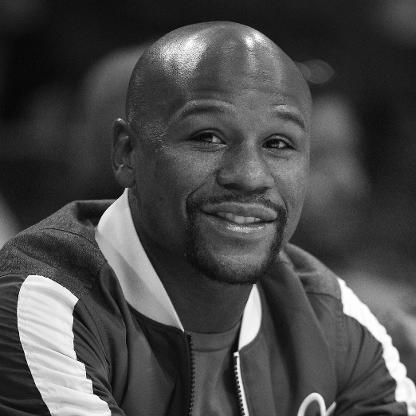

In [3]:
# The array is shown here as a list of lists, where the inner lists are filled with integers.
# The dtype=uint8 definition indicates that each of the items in an array is an 8 bit unsigned
# integer, which is very common for black and white images. So this is a pixel by pixel definition
# of the image.
#
# The display package, however, doesn't know what to do with this image. So lets convert it
# into a PIL object to render it in the browser.
from PIL import Image

# PIL can take an array of data with a given color format and convert this into a PIL object.
# This is perfect for our situation, as the PIL color mode, "L" is just an array of luminance
# values in unsigned integers
image = Image.fromarray(gray, "L")
display(image)

In [ ]:
# Lets talk a bit more about images for a moment. Numpy arrays are multidimensional. For 
# instance, we can define an array in a single dimension:
import numpy as np
single_dim = np.array([25, 50 , 25, 10, 10])

# In an image, this is analagous to a single row of 5 pixels each in grayscale. But actually,
# all imaging libraries tend to expect at least two dimensions, a width and a height, and to
# show a matrix. So if we put the single_dim inside of another array, this would be a two
# dimensional array with element in the height direction, and five in the width direction
double_dim = np.array([single_dim])

double_dim

In [ ]:
# This should look pretty familiar, it's a lot like a list of lists! Lets see what this new
# two dimensional array looks like if we display it
display(Image.fromarray(double_dim, "L"))

In [ ]:
# Pretty unexciting - it's just a little line. Five pixels in a row to be exact, of different
# levels of black. The numpy library has a nice attribute called shape that allows us to see how
# many dimensions big an array is. The shape attribute returns a tuple that shows the height of
# the image, by the width of the image
double_dim.shape

In [ ]:
# Lets take a look at the shape of our initial image which we loaded into the img variable
img.shape

In [4]:
# This image has three dimensions! That's because it has a width, a height, and what's called
# a color depth. In this case, the color is represented as an array of three values. Lets take a 
# look at the color of the first pixel
first_pixel=img[0][0]
first_pixel

array([33, 35, 53], dtype=uint8)

In [ ]:
# Here we see that the color value is provided in full RGB using an unsigned integer. This
# means that each color can have one of 256 values, and the total number of unique colors
# that can be represented by this data is 256 * 256 *256 which is roughly 16 million colors.
# We call this 24 bit color, which is 8+8+8.
#
# If you find yourself shopping for a television, you might notice that some expensive models
# are advertised as having 10 bit or even 12 bit panels. These are televisions where each of
# the red, green, and blue color channels are represented by 10 or 12 bits instead of 8. For
# ten bit panels this means that there are 1 billion colors capable, and 12 bit panels are
# capable of over 68 billion colors!

In [ ]:
# We're not going to talk much more about color in this course, but it's a fun subject. Instead,
# lets go back to this array representation of images, because we can do some interesting things
# with this.
#
# One of the most common things to do with an ndarray is to reshape it -- to change the number
# of rows and columns that are represented so that we can do different kinds of operations.
# Here is our original two dimensional image
print("Original image")
print(gray)
# If we wanted to represent that as a one dimensional image, we just call reshape
print("New image")
# And reshape takes the image as the first parameter, and a new shape as the second
image1d=np.reshape(gray,(1,gray.shape[0]*gray.shape[1]))
print(image1d)

In [5]:
# So, why are we talking about these nested arrays of bytes, we were supposed to be talking
# about OpenCV as a library. Well, I wanted to show you that often libraries working on the
# same kind of principles, in this case images stored as arrays of bytes, are not representing
# data in the same way in their APIs. But, by exploring a bit you can learn how the internal
# representation of data is stored, and build routines to convert between formats.
#
# For instance, remember in the last lecture when we wanted to look for gaps in an image so
# that we could draw lines to feed into kraken? Well, we use PIL to do this, using getpixel()
# to look at individual pixels and see what the luminosity was, then ImageDraw.rectangle to
# actually fill in a black bar separator. This was a nice high level API, and let us write
# routines to do the work we wanted without having to understand too much about how the images
# were being stored. But it was computationally very slow.
#
# Instead, we could write the code to do this using matrix features within numpy. Lets take
# a look.
import cv2 as cv
# We'll load the 2 column image
img = cv.imread('readonly/two_col.png')
# And we'll convert it to grayscale using the cvtColor image
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [6]:
# Now, remember how slicing on a list works, if you have a list of number such as 
# a=[0,1,2,3,4,5] then a[2:4] will return the sublist of numbers at position 2 through 4 
# inclusive - don't forget that lists start indexing at 0!
# If we have a two dimensional array, we can slice out a smaller piece of that using the
# format a[2:4,1:3]. You can think of this as first slicing along the rows dimension, then
# in the columns dimension. So in this example, that would be a matrix of rows 2, and 3,
# and columns 1, and 2. Here's a look at our image.
gray[2:4,1:3]

array([[255, 255],
       [255, 255]], dtype=uint8)

In [ ]:
# So we see that it is all white. We can use this as a "window" and move it around our
# our big image.
#
# Finally, the ndarray library has lots of matrix functions which are generally very fast
# to run. One that we want to consider in this case is count_nonzero(), which just returns
# the number of entries in the matrix which are not zero.
np.count_nonzero(gray[2:4,1:3])

In [11]:
# Ok, the last benefit of going to this low level approach to images is that we can change
# pixels very fast as well. Previously we were drawing rectangles and setting a fill and line
# width. This is nice if you want to do something like change the color of the fill from the
# line, or draw complex shapes. But we really just want a line here. That's really easy to
# do - we just want to change a number of luminosity values from 255 to 0.
#
# As an example, lets create a big white matrix
import numpy as np
white_matrix=np.full((12,12),255,dtype=np.uint8)
display(Image.fromarray(white_matrix, "L"))
# white_matrix

In [12]:
# looks pretty boring, it's just a giant white square we can't see. But if we want, we can
# easily color a column to be black
white_matrix[:,6]=np.full((1,12),0,dtype=np.uint8)
display(Image.fromarray(white_matrix,"L"))
white_matrix

array([[255, 255, 255, 255, 255, 255,   0, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255,   0, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255,   0, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255,   0, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255,   0, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255,   0, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255,   0, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255,   0, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255,   0, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255,   0, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255,   0, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255,   0, 255, 255, 255, 255, 255]],
      dtype=uint8)

In [ ]:
# And that's exactly what we wanted to do. So, why do it this way, when it seems so much
# more low level? Really, the answer is speed. This paradigm of using matricies to store
# and manipulate bytes of data for images is much closer to how low level API and hardware
# developers think about storing files and bytes in memory.
#
# How much faster is it? Well, that's up to you to discover; there's an optional assignment
# for this week to convert our old code over into this new format, to compare both the
# readability and speed of the two different approaches.

## OpenCV

In [13]:
# Ok, we're just about at the project for this course. If you reflect on the specialization 
# as a whole you'll realize that you started with probably little or no understanding of python,
# progressed through the basic control structures and libraries included with the language
# with the help of a digital textbook, moved on to more high level representations of data
# and functions with objects, and now started to explore third party libraries that exist for
# python which allow you to manipulate and display images. This is quite an achievement!
#
# You have also no doubt found that as you have progressed the demands on you to engage in self-
# discovery have also increased. Where the first assignments were maybe straight forward, the
# ones in this week require you to struggle a bit more with planning and debugging code as
# you develop.
#
# But, you've persisted, and I'd like to share with you just one more set of features before
# we head over to a project. The OpenCV library contains mechanisms to do face detection on
# images. The technique used is based on Haar cascades, which is a machine learning approach.
# Now, we're not going to go into the machine learning bits, we have another specialization on
# Applied Data Science with Python which you can take after this if you're interested in that topic.
# But here we'll treat OpenCV like a black box.
#
# OpenCV comes with trained models for detecting faces, eyes, and smiles which we'll be using.
# You can train models for detecting other things - like hot dogs or flutes - and if you're
# interested in that I'd recommend you check out the Open CV docs on how to train a cascade
# classifier: https://docs.opencv.org/3.4/dc/d88/tutorial_traincascade.html
# However, in this lecture we just want to use the current classifiers and see if we can detect
# portions of an image which are interesting.
#
# First step is to load opencv and the XML-based classifiers
import cv2 as cv
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')
eye_cascade = cv.CascadeClassifier('readonly/haarcascade_eye.xml')

In [14]:
# Ok, with the classifiers loaded, we now want to try and detect a face. Lets pull in the
# picture we played with last time
img = cv.imread('readonly/floyd.jpg')
# And we'll convert it to grayscale using the cvtColor image
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# The next step is to use the face_cascade classifier. I'll let you go explore the docs if you
# would like to, but the norm is to use the detectMultiScale() function. This function returns
# a list of objects as rectangles. The first parameter is an ndarray of the image.
faces = face_cascade.detectMultiScale(gray)
# And lets just print those faces out to the screen
faces

array([[158,  75, 176, 176]])

In [15]:
faces.tolist()[0]

[158, 75, 176, 176]

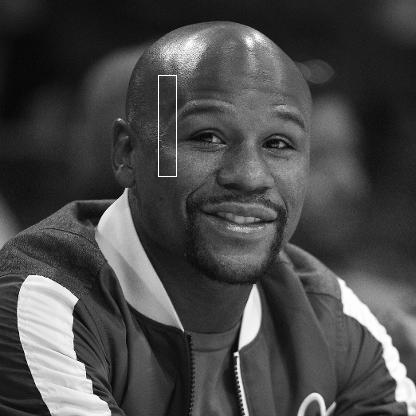

In [16]:
# The resulting rectangles are in the format of (x,y,w,h) where x and y denote the upper
# left hand point for the image and the width and height represent the bounding box. We know
# how to handle this in PIL
from PIL import Image

# Lets create a PIL image object
pil_img=Image.fromarray(gray,mode="L")

# Now lets bring in our drawing object
from PIL import ImageDraw
# And lets create our drawing context
drawing=ImageDraw.Draw(pil_img)

# Now lets pull the rectangle out of the faces object
rec=faces.tolist()[0]

# Now we just draw a rectangle around the bounds
drawing.rectangle(rec, outline="white")

# And display
display(pil_img)

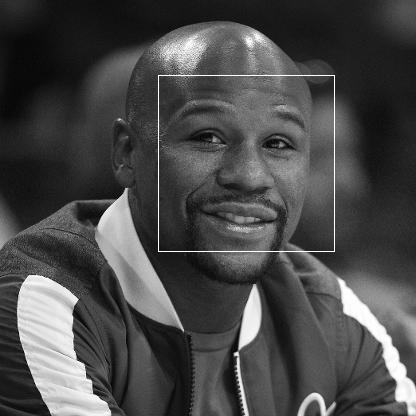

In [17]:
# So, not quite what we were looking for. What do you think went wrong?
# Well, a quick double check of the docs and it is apparent that OpenCV is return the coordinates
# as (x,y,w,h), while PIL.ImageDraw is looking for (x1,y1,x2,y2). Looks like an easy fix
# Wipe our old image
pil_img=Image.fromarray(gray,mode="L")
# Setup our drawing context
drawing=ImageDraw.Draw(pil_img)
# And draw the new box
drawing.rectangle((rec[0],rec[1],rec[0]+rec[2],rec[1]+rec[3]), outline="white")
# And display
display(pil_img)

In [18]:
# We see the face detection works pretty good on this image! Note that it's apparent that this is
# not head detection, but that the haarcascades file we used is looking for eyes and a mouth.
# Lets try this on something a bit more complex, lets read in our MSI recruitment image
img = cv.imread('readonly/msi_recruitment.gif')
# And lets take a look at that image
display(Image.fromarray(img))

AttributeError: 'NoneType' object has no attribute '__array_interface__'

In [19]:
# Whoa, what's that error about? It looks like there is an error on a line deep within the PIL
# Image.py file, and it is trying to call an internal private member called __array_interface__
# on the img object, but this object is None
#
# It turns out that the root of this error is that OpenCV can't work with Gif images. This is
# kind of a pain and unfortunate. But we know how to fix that right? One way is that we could
# just open this in PIL and then save it as a png, then open that in open cv.
#
# Lets use PIL to open our image
pil_img=Image.open('readonly/msi_recruitment.gif')
# now lets convert it to greyscale for opencv, and get the bytestream
open_cv_version=pil_img.convert("L")
# now lets just write that to a file
open_cv_version.save("msi_recruitment.png")

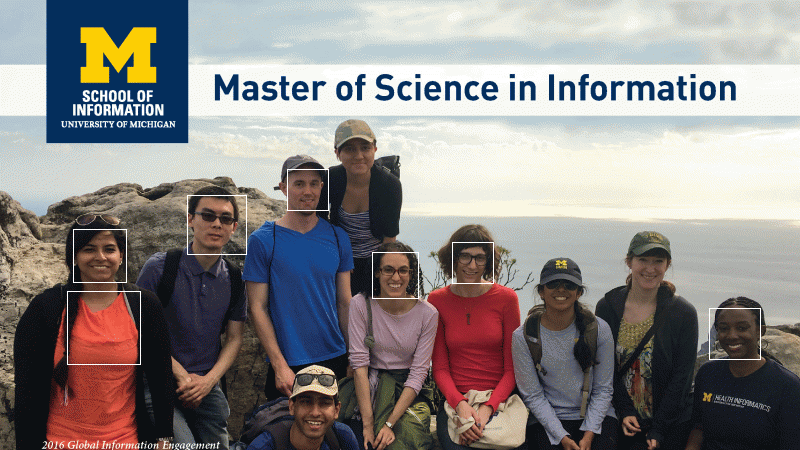

In [20]:
# Ok, now that the conversion of format is done, lets try reading this back into opencv
cv_img=cv.imread('msi_recruitment.png')
# We don't need to color convert this, because we saved it as grayscale
# lets try and detect faces in that image
faces = face_cascade.detectMultiScale(cv_img)

# Now, we still have our PIL color version in a gif
pil_img=Image.open('readonly/msi_recruitment.gif')
# Set our drawing context
drawing=ImageDraw.Draw(pil_img)

# For each item in faces, lets surround it with a red box
for x,y,w,h in faces:
    # That might be new syntax for you! Recall that faces is a list of rectangles in (x,y,w,h)
    # format, that is, a list of lists. Instead of having to do an iteration and then manually
    # pull out each item, we can use tuple unpacking to pull out individual items in the sublist
    # directly to variables. A really nice python feature
    #
    # Now we just need to draw our box
    drawing.rectangle((x,y,x+w,y+h), outline="white")
display(pil_img)

In [21]:
# What happened here!? We see that we have detected faces, and that we have drawn boxes
# around those faces on the image, but that the colors have gone all weird! This, it turns
# out, has to do with color limitations for gif images. In short, a gif image has a very
# limited number of colors. This is called a color pallette after the pallette artists
# use to mix paints. For gifs the pallette can only be 256 colors -- but they can be *any*
# 256 colors. When a new color is introduced, is has to take the space of an old color.
# In this case, PIL adds white to the pallette but doesn't know which color to replace and
# thus messes up the image.
#
# Who knew there was so much to learn about image formats? We can see what mode the image
# is in with the .mode attributes 
# 1 (1-bit pixels, black and white, stored with one pixel per byte)
# L (8-bit pixels, black and white)
# P (8-bit pixels, mapped to any other mode using a color palette)
# RGB (3x8-bit pixels, true color)
pil_img.mode

'P'

In [22]:
# We can see a list of modes in the PILLOW documentation, and they correspond with the
# color spaces we have been using. For the moment though, lets change back to RGB, which
# represents color as a three byte tuple instead of in a pallette.
# Lets read in the image
pil_img=Image.open('readonly/msi_recruitment.gif')
# Lets convert it to RGB mode
pil_img = pil_img.convert("RGB")
# And lets print out the mode
pil_img.mode

'RGB'

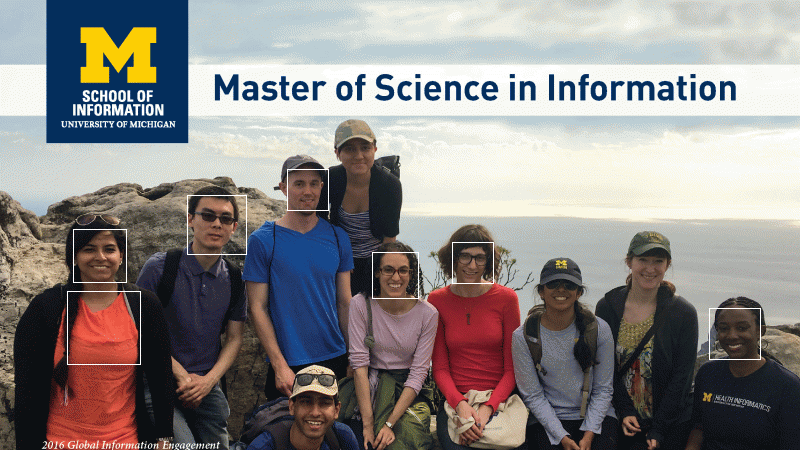

In [23]:
# Ok, now lets go back to drawing rectangles. Lets get our drawing object
drawing=ImageDraw.Draw(pil_img)
# And iterate through the faces sequence, tuple unpacking as we go
for x,y,w,h in faces:
    # And remember this is width and height so we have to add those appropriately.
    drawing.rectangle((x,y,x+w,y+h), outline="white")
display(pil_img)

In [ ]:
# Awesome! We managed to detect a bunch of faces in that image. Looks like we have missed 
# four faces. In the machine learning world we would call these false negatives - something
# which the machine thought was not a face (so a negative), but that it was incorrect on.
# Consequently, we would call the actual faces that were detected as true positives -
# something that the machine thought was a face and it was correct on. This leaves us with
# false positives - something the machine thought was a face but it wasn't. We see there are
# two of these in the image, picking up shadow patterns or textures in shirts and matching
# them with the haarcascades. Finally, we have true negatives, or the set of all possible
# rectangles the machine learning classifier could consider where it correctly indicated that
# the result was not a face. In this case there are many many true negatives.

In [24]:
# There are a few ways we could try and improve this, and really, it requires a lot of 
# experimentation to find good values for a given image. First, lets create a function
# which will plot rectanges for us over the image
def show_rects(faces):
    #Lets read in our gif and convert it
    pil_img=Image.open('readonly/msi_recruitment.gif').convert("RGB")
    # Set our drawing context
    drawing=ImageDraw.Draw(pil_img)
    # And plot all of the rectangles in faces
    for x,y,w,h in faces:
        drawing.rectangle((x,y,x+w,y+h), outline="white")
    #Finally lets display this
    display(pil_img)

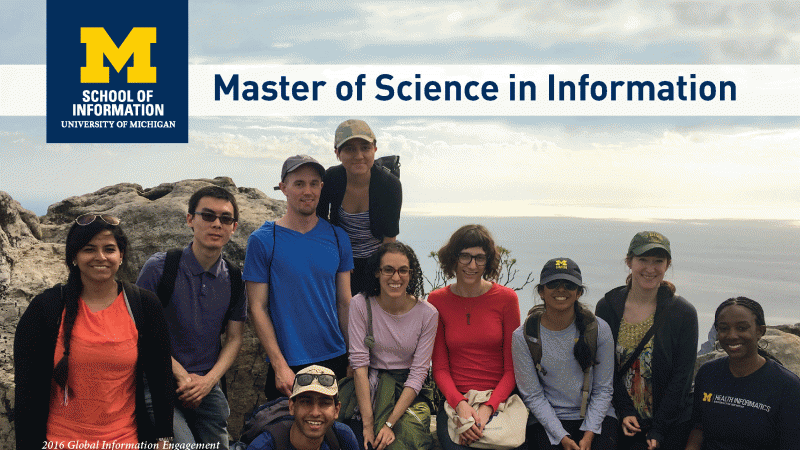

In [39]:
# Ok, first up, we could try and binarize this image. It turns out that opencv has a built in
# binarization function called threshold(). You simply pass in the image, the midpoint, and
# the maximum value, as well as a flag which indicates whether the threshold should be
# binary or something else. Lets try this.
cv_img_bin=cv.threshold(img,180,255,cv.THRESH_BINARY)[1] # returns a list, we want the second value
# Now do the actual face detection
faces = face_cascade.detectMultiScale(cv_img_bin)
# Now lets see the results
show_rects(faces)

In [40]:
# That's kind of interesting. Not better, but we do see that there is one false positive
# towards the bottom, where the classifier detected the sunglasses as eyes and the dark shadow
# line below as a mouth.
#
# If you're following in the notebook with this video, why don't you pause things and try a
# few different parameters for the thresholding value?

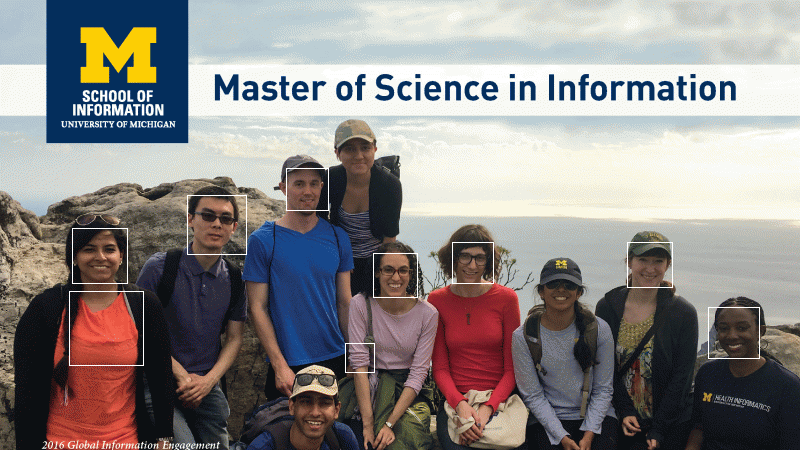

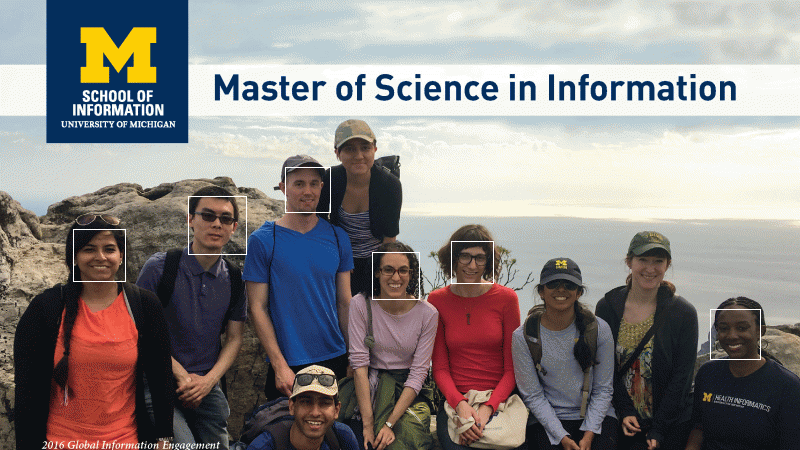

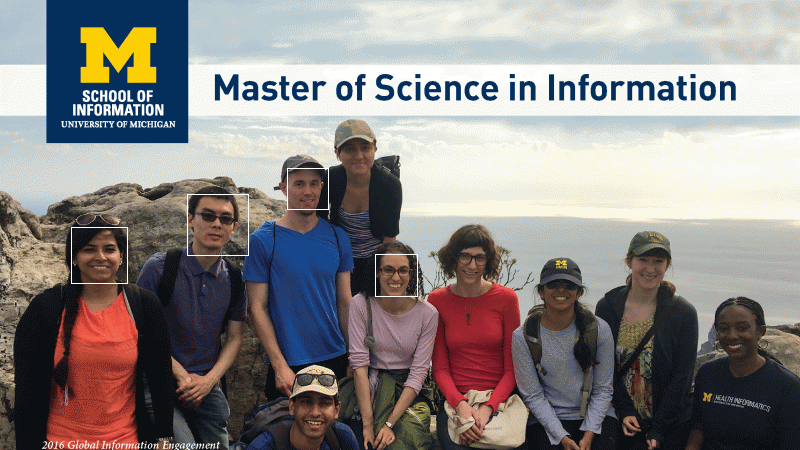

In [41]:
# The detectMultiScale() function from OpenCV also has a couple of parameters. The first of
# these is the scale factor. The scale factor changes the size of rectangles which are
# considered against the model, that is, the haarcascades XML file. You can think of it as if
# it were changing the size of the rectangles which are on the screen.
#
# Lets experiment with the scale factor. Usually it's a small value, lets try 1.05
faces = face_cascade.detectMultiScale(cv_img,1.05)
# Show those results
show_rects(faces)
# Now lets also try 1.15
faces = face_cascade.detectMultiScale(cv_img,1.15)
# Show those results
show_rects(faces)
# Finally lets also try 1.25
faces = face_cascade.detectMultiScale(cv_img,1.25)
# Show those results
show_rects(faces)

In [ ]:
# We can see that as we change the scale factor we change the number of true and 
# false positives and negatives. With the scale set to 1.05, we have 7 true positives,
# which are correctly identified faces, and 3 false negatives, which are faces which
# are there but not detected, and 3 false positives, where are non-faces which
# opencv thinks are faces. When we change this to 1.15 we lose the false positives but
# also lose one of the true positives, the person to the right wearing a hat. And
# when we change this to 1.25 we lost more true positives as well.
#
# This is actually a really interesting phenomena in machine learning and artificial
# intelligence. There is a trade off between not only how accurate a model is, but how
# the inaccuracy actually happens. Which of these three models do you think is best?

In [42]:
# Well, the answer to that question is really, "it depends". It depends why you are trying
# to detect faces, and what you are going to do with them. If you think these issues
# are interesting, you might want to check out the Applied Data Science with Python
# specialization Michigan offers on Coursera.
#
# Ok, beyond an opportunity to advertise, did you notice anything else that happened when
# we changed the scale factor? It's subtle, but the speed at which the processing ran
# took longer at smaller scale factors. This is because more subimages are being considered
# for these scales. This could also affect which method we might use.
#
# Jupyter has nice support for timing commands. You might have seen this before, a line
# that starts with a percentage sign in jupyter is called a "magic function". This isn't
# normal python - it's actually a shorthand way of writing a function which Jupyter
# has predefined. It looks a lot like the decorators we talked about in a previous
# lecture, but the magic functions were around long before decorators were part of the
# python language. One of the built-in magic functions in juptyer is called timeit, and this
# repeats a piece of python ten times (by default) and tells you the average speed it
# took to complete.
#
# Lets time the speed of detectmultiscale when using a scale of 1.05
%timeit face_cascade.detectMultiScale(cv_img,1.05)

87.8 ms ± 2.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
# Ok, now lets compare that to the speed at scale = 1.15
%timeit face_cascade.detectMultiScale(cv_img,1.15)

36.2 ms ± 575 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
# You can see that this is a dramatic difference, roughly two and a half times slower
# when using the smaller scale!
#
# This wraps up our discussion of detecting faces in opencv. You'll see that, like OCR, this
# is not a foolproof process. But we can build on the work others have done in machine learning
# and leverage powerful libraries to bring us closer to building a turn key python-based
# solution. Remember that the detection mechanism isn't specific to faces, that's just the
# haarcascades training data we used. On the web you'll be able to find other training data
# to detect other objects, including eyes, animals, and so forth.

## More Jupyter Widgets

In [45]:
# One of the nice things about using the Jupyter notebook systems is that there is a
# rich set of contributed plugins that seek to extend this system. In this lecture I
# want to introduce you to one such plugin, call ipy web rtc. Webrtc is a fairly new
# protocol for real time communication on the web. Yup, I'm talking about chatting.
# The widget brings this to the Jupyter notebook system. Lets take a look.
#
# First, lets import from this library two different classes which we'll use in a
# demo, one for the camera and one for images.
from ipywebrtc import CameraStream, ImageRecorder
# Then lets take a look at the camera stream object
help(CameraStream)

Help on class CameraStream in module ipywebrtc.webrtc:

class CameraStream(MediaStream)
 |  CameraStream(*args, **kwargs)
 |  
 |  Represents a media source by a camera/webcam/microphone using
 |  getUserMedia. See
 |  https://developer.mozilla.org/en-US/docs/Web/API/MediaDevices/getUserMedia
 |  for more detail.
 |  The constraints trait can be set to specify constraints for the camera or
 |  microphone, which is described in the documentation of getUserMedia, such
 |  as in the link above,
 |  Two convenience methods are avaiable to easily get access to the 'front'
 |  and 'back' camera, when present
 |  
 |  >>> CameraStream.facing_user(audio=False)
 |  >>> CameraStream.facing_environment(audio=False)
 |  
 |  Method resolution order:
 |      CameraStream
 |      MediaStream
 |      ipywidgets.widgets.domwidget.DOMWidget
 |      ipywidgets.widgets.widget.Widget
 |      ipywidgets.widgets.widget.LoggingHasTraits
 |      traitlets.traitlets.HasTraits
 |      traitlets.traitlets.HasDes

In [46]:
# We see from the docs that it's east to get a camera facing the user, and we can have
# the audio on or off. We don't need audio for this demo, so lets create a new camera
# instance
camera = CameraStream.facing_user(audio=False)
# The next object we want to look at is the ImageRecorder
help(ImageRecorder)

Help on class ImageRecorder in module ipywebrtc.webrtc:

class ImageRecorder(Recorder)
 |  ImageRecorder(format='png', filename='record', recording=False, autosave=False, **kwargs)
 |  
 |  Creates a recorder which allows to grab an Image from a MediaStream widget.
 |  
 |  Method resolution order:
 |      ImageRecorder
 |      Recorder
 |      ipywidgets.widgets.domwidget.DOMWidget
 |      ipywidgets.widgets.widget.Widget
 |      ipywidgets.widgets.widget.LoggingHasTraits
 |      traitlets.traitlets.HasTraits
 |      traitlets.traitlets.HasDescriptors
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, format='png', filename='record', recording=False, autosave=False, **kwargs)
 |      Public constructor
 |  
 |  save(self, filename=None)
 |      Save the image to a file, if no filename is given it is based on the filename trait and the format.
 |      
 |      >>> recorder = ImageRecorder(filename='test', format='png')
 |      >>> ...
 |      >>> recorder.sa

In [48]:
# The image recorder lets us actually grab images from the camera stream. There are features
# for downloading and using the image as well. We see that the default format is a png file.
# Lets hook up the ImageRecorder to our stream
image_recorder = ImageRecorder(stream=camera)
# Now, the docs are a little unclear how to use this within Jupyter, but if we call the
# download() function it will actually store the results of the camera which is hooked up
# in image_recorder.image. Lets try it out
# First, lets tell the recorder to start capturing data
image_recorder.recording=True
# Now lets download the image
image_recorder.download()
# Then lets inspect the type of the image
type(image_recorder.image)

ipywidgets.widgets.widget_media.Image

In [ ]:
# Ok, the object that it stores is an ipywidgets.widgets.widget_media.Image. How do we do
# something useful with this? Well, an inspection of the object shows that there is a handy
# value field which actually holds the bytes behind the image. And we know how to display
# those.
# Lets import PIL Image
import PIL.Image
# And lets import io
import io
# And now lets create a PIL image from the bytes
img = PIL.Image.open(io.BytesIO(image_recorder.image.value))
# And render it to the screen
display(img)

In [ ]:
# Great, you see a picture! Hopefully you are following along in one of the notebooks
# and have been able to try this out for yourself!
#
# What can you do with this? This is a great way to get started with a bit of computer vision.
# You already know how to identify a face in the webcam picture, or try and capture text
# from within the picture. With OpenCV there are any number of other things you can do, simply
# with a webcam, the Jupyter notebooks, and python!